In [17]:
from IPython.display import Image
%matplotlib inline

단층신경망

In [18]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_01.png', width=600)

다층신경망

In [19]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_02.png', width=600)

정방향 계산으로 신경망 활성화 출력 계산

In [20]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml('mnist_784',version=1, return_X_y=True, parser='auto')
X=X.values
y=y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [21]:
X = ((X / 255) - 0.5)*2

각 클래스의 첫 번째 이미지를 그린다

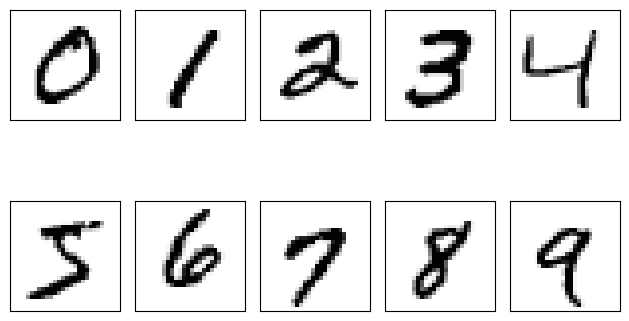

In [22]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
  img = X[y==i][0].reshape(28,28)
  ax[i].imshow(img, cmap='Greys')
  ax[i].set_xticks([])
  ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
X_temp, X_test,y_temp,y_test =  train_test_split(X,y,test_size=10000,random_state=123,stratify=y)
X_train, X_valid,y_train,y_valid =  train_test_split(X_temp,y_temp,test_size=5000,random_state=123,stratify=y_temp)

# 데이터 분할용으로 사용한 변수는 삭제해서  memory 용량 확보
del X_temp, y_temp, X,y

다층 퍼셉트론 구현

In [24]:
import numpy as np

In [25]:
rng = np.random.RandomState(10)
rng.normal(
        loc=0.0, scale=0.1,size=(10,10))

array([[ 0.13315865,  0.0715279 , -0.15454003, -0.00083838,  0.0621336 ,
        -0.07200856,  0.02655116,  0.01085485,  0.00042914, -0.01746002],
       [ 0.04330262,  0.12030374, -0.09650657,  0.10282741,  0.02286301,
         0.04451376, -0.11366022,  0.01351369,  0.1484537 , -0.10798049],
       [-0.19777283, -0.17433723,  0.02660702,  0.23849673,  0.11236913,
         0.16726222,  0.00991492,  0.13979964, -0.0271248 ,  0.06132042],
       [-0.02673172, -0.0549309 ,  0.01327083, -0.0476142 ,  0.13084731,
         0.01950133,  0.040021  , -0.03376323,  0.12564723, -0.07319695],
       [ 0.06602316, -0.03508719, -0.09394334, -0.04893372, -0.08045911,
        -0.02126976, -0.03391402,  0.03121699,  0.05651527, -0.01474203],
       [-0.00259053,  0.02890942, -0.05398791,  0.070816  ,  0.08422247,
         0.02035808,  0.23947037,  0.09174589, -0.01122725, -0.03621804],
       [-0.02321823, -0.05017289,  0.11287852, -0.069781  , -0.00811222,
        -0.05292961,  0.10461829, -0.1418556 

In [35]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # 은닉층
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # 출력층
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # 은닉층
        # 입력 차원: [n_examples, n_features] dot [n_hidden, n_features].T
        # 출력 차원: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # 출력층
        # 입력 차원: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # 출력 차원: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### 출력층 가중치
        #########################

        # 원-핫 인코딩
        y_onehot = int_to_onehot(y, self.num_classes)

        # 파트 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## 재사용을 위해 DeltaOut = dLoss/dOutAct * dOutAct/dOutNet

        # 입력/출력 차원: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # 입력/출력 차원: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # 출력 차원: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # 출력 가중치를 위한 그레이디언트

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # 입력 차원: [n_classes, n_examples] dot [n_examples, n_hidden]
        # 출력 차원: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # 파트 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # 출력 차원: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # 출력 차원: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)


In [36]:
model = NeuralNetMLP(num_features=28*28,num_hidden=50,num_classes=10)

신경망 훈련 루프 코딩
  - 데이터 로더 정의하기

In [37]:
import numpy as np
num_epochs = 50
minibatch_size = 100

In [38]:
def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    yield X[batch_idx], y[batch_idx]

# 훈련 에포크를 반복
for i in range(num_epochs):
  # 미니배치 반복
  minibach_gen = minibatch_generator(X_train,y_train,minibatch_size)
  for X_train_mini, y_train_mini in minibach_gen:
    break
  break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


손실 및 정확도를 계산하는 함수 정의하기

In [39]:
def mse_loss(targets,probas,num_labels=10):
  onehot_targets = int_to_onehot(targets, num_labels=num_labels)
  return np.mean((onehot_targets - probas)**2)

def accuracy(targets,predicted_labels)  :
  return np.mean(predicted_labels == targets)

_,probas =  model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f"검증 세트 MSE : {mse:.1f}")
print(f"검증 세트 정확도:{acc*100: .1f}")

검증 세트 MSE : 0.3
검증 세트 정확도: 9.4


In [40]:
def compute_mse_and_acc(nnet, X, y ,num_labels=10, minibatch_size=100):
  mse,correct_pred, num_examples = 0,0,0
  minibatch_gen = minibatch_generator(X,y,minibatch_size)
  for i, (features, targets) in enumerate(minibatch_gen):
    _, probas = nnet.forward(features)
    predicted_labels = np.argmax(probas, axis=1)
    onehot_targets = int_to_onehot(targets,num_labels = num_labels)
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == targets).sum()
    num_examples += targets.shape[0]
  mse = mse/i
  acc = correct_pred / num_examples
  return mse, acc

In [41]:
mse,acc = compute_mse_and_acc(model,X_valid,y_valid)
print(f"검증 세트 MSE:{mse:.5f}")
print(f"검증 세트 정확도:{acc*100:.5f}")

검증 세트 MSE:0.00000
검증 세트 정확도:9.36000


훈련함수 정의
  - 에포크 수 만큼 순환

In [42]:
def train(model, X_train, y_train, X_valid,y_valid, num_epochs, learning_rate = 0.1):
  epoch_loss = []
  epoch_train_acc = []
  epoch_valid_acc = []
  for e in range(num_epochs):
    # 미니배치를 반복합니다.
    minibatch_gen = minibatch_generator(
        X_train,y_train, minibatch_size
    )
    for X_train_mini, y_train_mini in minibatch_gen:
      ### 출력 계산 ###
      a_h, a_out = model.forward(X_train_mini)

      ### 그레이디언트 계산 ###
      d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
        model.backward(X_train_mini, a_h, a_out, y_train_mini)

      ### 가중치 업데이트 ###
      model.weight_h -= learning_rate * d_loss__d_w_h
      model.bias_h -= learning_rate * d_loss__d_b_h
      model.weight_out -= learning_rate * d_loss__d_w_out
      model.bias_out -= learning_rate * d_loss__d_b_out
    ### 에포크 로깅 ###
    train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
    valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
    train_acc, valid_acc = train_acc*100, valid_acc * 100
    epoch_train_acc.append(train_acc)
    epoch_valid_acc.append(valid_acc)
    epoch_loss.append(train_mse)
    print(f"에포크 : {e+1:03d} / {num_epochs:03d} | 훈련mse:{train_mse:.2f} | 훈련 정확도 ㅣ {train_acc : .2f} | 검증 정확도 : {valid_acc:.2f}" )
  return epoch_loss, epoch_train_acc, epoch_valid_acc

In [44]:
np.random.seed(123)
epoch_loss, epoch_train_acc , epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid, num_epochs=50,  learning_rate = 0.1
)

에포크 : 001 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  90.11 | 검증 정확도 : 89.94
에포크 : 002 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  90.56 | 검증 정확도 : 90.30
에포크 : 003 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  91.09 | 검증 정확도 : 90.94
에포크 : 004 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  91.50 | 검증 정확도 : 91.22
에포크 : 005 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  91.85 | 검증 정확도 : 91.44
에포크 : 006 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  91.98 | 검증 정확도 : 91.74
에포크 : 007 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  92.25 | 검증 정확도 : 91.84
에포크 : 008 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  92.44 | 검증 정확도 : 92.10
에포크 : 009 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  92.68 | 검증 정확도 : 92.26
에포크 : 010 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  92.87 | 검증 정확도 : 92.64
에포크 : 011 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  93.04 | 검증 정확도 : 92.78
에포크 : 012 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  93.15 | 검증 정확도 : 92.78
에포크 : 013 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  93.21 | 검증 정확도 : 92.92
에포크 : 014 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  93.36 | 검증 정확도 : 93.18
에포크 : 015 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ  93.50 | 검증 정확도 : 93.32
에포크 : 016 / 050 | 훈련mse:0.00 | 훈련 정확도 ㅣ 

모델 성능평가

In [ ]:
epoch_loss

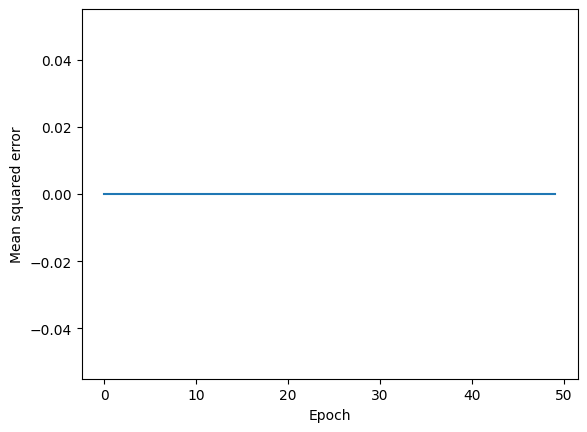

In [46]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

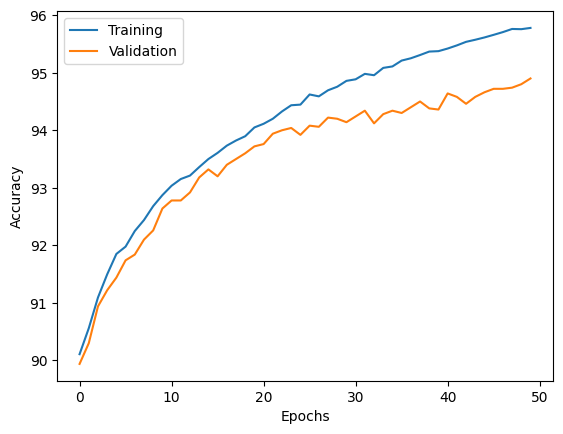

In [48]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training'  )
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation'  )
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [50]:
test_mse, test_acc =  compute_mse_and_acc(model, X_test, y_test)
print(f'테스트 정확도 : {test_acc*100: .2f}')

테스트 정확도 :  94.70


예측 실패 샘플 출력하기

In [51]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_,probas =  model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images =  X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]

correct_labels = y_test_subset[y_test_subset != test_pred][:25]

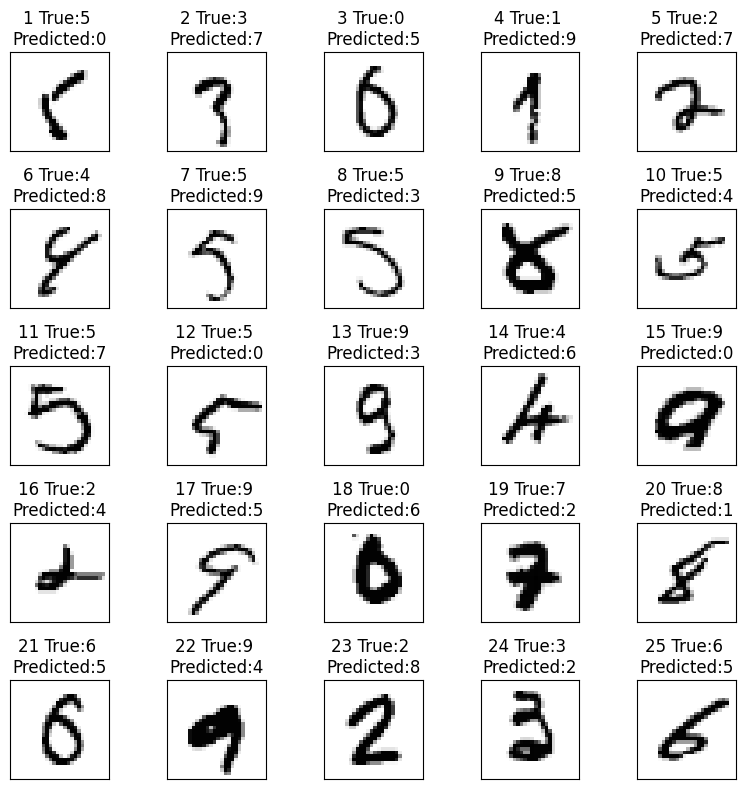

In [54]:
fig,ax =  plt.subplots(5,5,sharex=True, sharey=True, figsize=(8,8))
ax = ax.flatten()
for i in range(25):
  img = misclassified_images[i].reshape(28,28)
  ax[i].imshow(img, cmap='Greys', interpolation='nearest')
  ax[i].set_title(f'{i+1} True:{correct_labels[i]} \nPredicted:{misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

인공신경망 훈련
  - 손실함수 계산

In [55]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_10.png', width=300)

In [56]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_11.png', width=400)

In [57]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_12.png', width=500)

In [58]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_13.png', width=500)

신경망의 수렴

In [59]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_14.png', width=500)